This notebook is to establish the baseline for the project. Here I used the data from paper (Heng, Yujing J., et al). For survival analysis, both KaplanMeier and Cox Proportional Hazards (CoxPH) were implemented. In doing so, I could assess the prognostic accuracy of baseline linear Cox models generated using manual histologic features.

Heng, Yujing J., et al. "The molecular basis of breast cancer pathological phenotypes." The Journal of pathology 241.3 (2017): 375-391.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import lifelines as ll
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.utils import concordance_index

ModuleNotFoundError: No module named 'lifelines'

In [4]:
# morph = pd.read_csv('../data/Morphologic consensus.csv')

# outcome = pd.read_excel('base_info.xlsx')

# outcome.set_index('case_id', inplace=True)

# bind = outcome.merge(morph, left_index=True, right_on='sample')

# len(bind)

# len(morph)

# set(morph['sample'].tolist()) - set(bind['sample'].tolist())

# bind['duration'] = bind['days_to_last_follow_up']

# bind.loc[pd.notna(bind['days_to_death']).tolist(), 'duration'] = bind.loc[pd.notna(bind['days_to_death']).tolist(), 'days_to_death']

# bind.loc[np.isnan(bind['duration'])] # have checked in TCGA, data lack comfirmed

# bind.drop(846, inplace=True)

# bind['observed'] = pd.notna(bind['days_to_death']).tolist()

# target_raw = bind[(bind['duration'] != 0) & (bind['gender'] == 'female')]

# target_raw.to_excel('bind.xlsx')

# temp = target_raw.drop(['updated_datetime', 'year_of_birth', 'days_to_death', 'days_to_last_follow_up', 'gene_exp'], axis=1)

# temp_drop = temp.dropna()

# len(temp_drop)

In [5]:
temp_drop = pd.read_excel('../data/Hist.xlsx')

In [6]:
len(temp_drop)

760

In [8]:
samples = pd.read_excel('../data/samples.xlsx')

In [9]:
samples.head()

,sample
0,TCGA-C8-A275
1,TCGA-AN-A0AM
2,TCGA-C8-A1HJ
3,TCGA-AN-A0XU
4,TCGA-AN-A0FV


In [10]:
temp_drop = temp_drop.set_index('sample').loc[samples['sample']]

In [11]:
target = temp_drop.loc[:,['duration', 'observed']]
# target.to_excel('Target.xlsx')

In [12]:
temp_drop.isna().sum()

gender              0
age_at_diagnosis    0
epi_area            0
inflam              0
lcis                0
apo_feat            0
dcis                0
epi_tube            0
lymp                0
necrosis            0
nuc_pleo            0
fib_focus           0
mitosis             0
hist_type           0
duration            0
observed            0
dtype: int64

temp_drop.to_excel('temp_drop.xlsx')

In [13]:
T = temp_drop["duration"]
E = temp_drop["observed"]
kmf = ll.KaplanMeierFitter()
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter: fitted with 759 observations, 641 censored>

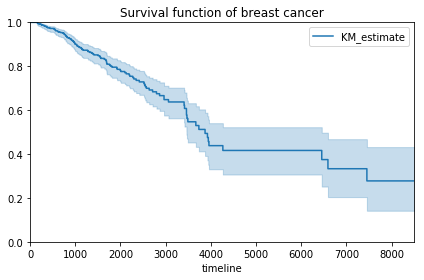

In [14]:
kmf.plot()
plt.ylim(0, 1);
plt.xlim(0, 8500);
plt.title('Survival function of breast cancer');
plt.tight_layout()
plt.savefig('km.png', dpi=300)

In [ ]:
temp_drop.columns

In [35]:
dummy = pd.get_dummies(temp_drop.loc[:, 'epi_area': 'observed'], drop_first=True)

ages = temp_drop['age_at_diagnosis'].values
ages_min = min(ages)
dummy['age_at_diagnosis'] = (ages - ages_min) / (max(ages) - ages_min)

In [18]:
dummy.to_excel('../data/dummy.xlsx')

In [36]:
from sklearn.model_selection import train_test_split

In [40]:
len(train)

607

In [70]:
cph = ll.CoxPHFitter()
cph.fit(dummy, duration_col='duration', event_col='observed', show_progress=False)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 759 observations, 641 censored>
      duration col = 'duration'
         event col = 'observed'
number of subjects = 759
  number of events = 118
    log-likelihood = -589.47
  time fit was run = 2019-04-02 12:31:08 UTC

---
                                               coef  exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
epi_area_<25% (Low)                            0.63       1.89      0.31  2.02   0.04      4.53        0.02        1.25
epi_area_>75% (High)                          -0.15       0.86      0.24 -0.63   0.53      0.92       -0.63        0.32
inflam_Present                                -0.88       0.41      0.25 -3.52 <0.005     11.19       -1.38       -0.39
lcis_Present                                  -0.06       0.94      0.45 -0.13   0.90      0.15       -0.94        0.82
apo_feat_6-50% (Moderate)                     -0.40       0.67      0.77 -0.52   0.61      0.72       -1.90        1.11
apo_feat_>50% (Mark

In [79]:
from collections import defaultdict
def result():
    noage = defaultdict(list)
    age = defaultdict(list)
    for _ in range(40):
        train, test = train_test_split(dummy, test_size=0.2)
        cph_noage = ll.CoxPHFitter()
        cph_noage.fit(train.drop('age_at_diagnosis', axis=1), duration_col='duration', event_col='observed', show_progress=False)
        noage['train'].append(cph_noage.score_)
        noage['test'].append(concordance_index(test['duration'], -cph_noage.predict_partial_hazard(test.drop('age_at_diagnosis', axis=1)), test['observed']))

        cph_age = ll.CoxPHFitter()
        cph_age.fit(train, duration_col='duration', event_col='observed', show_progress=False)
        age['train'].append(cph_age.score_)
        age['test'].append(concordance_index(test['duration'], -cph_age.predict_partial_hazard(test), test['observed']))
    ret_pd = pd.DataFrame({'train':noage['train']+age['train'], 'test':noage['test']+age['test'], 'withage':[False]*40+[True]*40})
    return ret_pd

In [80]:
ret_pd = result()

C:\Anaconda3\envs\eos\lib\site-packages\lifelines\fitters\coxph_fitter.py:549: ConvergenceWarning: Newton-Rhapson convergence completed but norm(delta) is still high, 0.525. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?
  ConvergenceWarning,
C:\Anaconda3\envs\eos\lib\site-packages\lifelines\fitters\coxph_fitter.py:549: ConvergenceWarning: Newton-Rhapson convergence completed but norm(delta) is still high, 0.546. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?
  ConvergenceWarning,


In [95]:
ret_pd.to_excel('../data/ret_man.xlsx')

In [82]:
ret_pd_re = ret_pd.append(ret_pd)
ret_pd_re['c index'] = ret_pd.train.append(ret_pd.test)
ret_pd_re['类型'] = '训练'
ret_pd_re['类型'][len(ret_pd):] = '测试'
ret_pd_re['含年龄特征'] = ret_pd_re['withage'].map({False:'否', True:'是'})

C:\Anaconda3\envs\eos\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


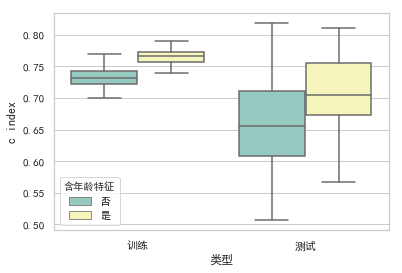

In [87]:
plt.figure()
sns.boxplot(x='类型', y='c index', hue='含年龄特征', data=ret_pd_re, palette='Set3')
plt.savefig('mannul.png', dpi=300)

In [88]:
from scipy.stats import ttest_ind

In [94]:
print('no age')
ret_pd.loc[ret_pd['withage']==False].describe()

no age


,train,test
count,40.000000,40.000000
mean,0.732695,0.656730
std,0.014922,0.063474
min,0.700473,0.506057
25%,0.722067,0.608790
50%,0.732077,0.656043
75%,0.742115,0.711139
max,0.770200,0.819158


In [93]:
print('age')
ret_pd.loc[ret_pd['withage']==True].describe()

age


,train,test
count,40.000000,40.000000
mean,0.765830,0.706979
std,0.012272,0.057699
min,0.739854,0.566929
25%,0.756764,0.673174
50%,0.765779,0.704613
75%,0.773488,0.755971
max,0.790084,0.810997


In [96]:
ttest_ind(ret_pd.loc[ret_pd['withage']==False, 'train'], ret_pd.loc[ret_pd['withage']==True, 'train'])

Ttest_indResult(statistic=-10.846836230478281, pvalue=3.0553017048160365e-17)

In [97]:
ttest_ind(ret_pd.loc[ret_pd['withage']==False, 'test'], ret_pd.loc[ret_pd['withage']==True, 'test'])

Ttest_indResult(statistic=-3.704860935539933, pvalue=0.00039327600928409294)

In [98]:
ttest_ind(ret_pd.loc[ret_pd['withage']==False, 'train'], ret_pd.loc[ret_pd['withage']==False, 'test'])

Ttest_indResult(statistic=7.368339610305623, pvalue=1.5568212523236574e-10)

In [99]:
ttest_ind(ret_pd.loc[ret_pd['withage']==True, 'train'], ret_pd.loc[ret_pd['withage']==True, 'test'])

Ttest_indResult(statistic=6.309693789526252, pvalue=1.5677811762062102e-08)

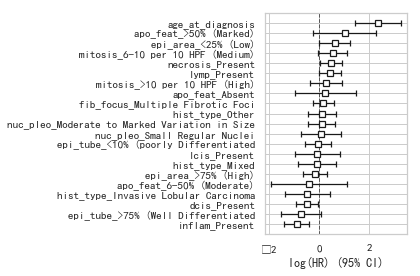

In [60]:
f, ax = plt.subplots()
cph.plot(ax=ax)
plt.tight_layout()
plt.savefig('cph.png', dpi=300)

In [57]:
import matplotlib as mpl

sns.set()
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']

sns.set_style("whitegrid",{"font.sans-serif":['simhei', 'Arial']})

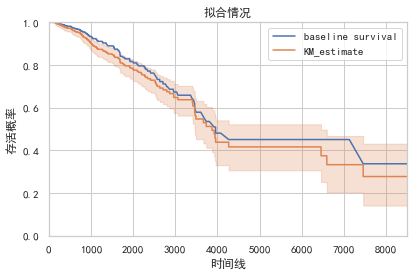

In [59]:
_, ax = plt.subplots()
plt.ylim(0, 1);
plt.xlim(0, 8500);
cph_age.baseline_survival_.plot(ax=ax)
kmf.plot(ax=ax)
ax.set_title('拟合情况')
plt.xlabel('时间线')
plt.ylabel('存活概率')
plt.tight_layout()
plt.savefig('Goodness of fit.png', dpi=300)

In [23]:
from lifelines.utils import k_fold_cross_validation

In [34]:
cph = ll.CoxPHFitter()
scores = k_fold_cross_validation(cph, dummy, 'duration', event_col='observed', k=5)
print(scores)
print(np.mean(scores))
print(np.std(scores))

[0.7445980985306828, 0.7327473958333334, 0.5883792048929664, 0.5641891891891891, 0.5804380664652568]
0.6420703909822857
0.07934862129321957


In [36]:
file_num = [1062, 846, 760, 642]
pie_num = [file_num[i] - file_num[i+1] if i < len(file_num) - 1 else file_num[i] for i in range(len(file_num))]

In [37]:
pie_name = ['Out of the paper', 'Gender male or data deficit', 'Event observed', 'Censored']

In [38]:
pct = [str(pie_num[i]) + ' ' + pie_name[i] for i in range(len(pie_name))]

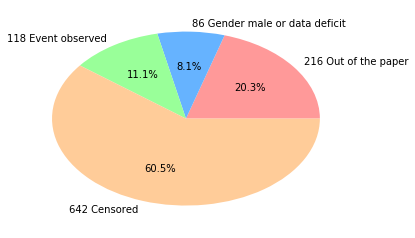

In [39]:
plt.figure()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(pie_num, labels=pct, colors=colors, autopct='%1.1f%%');
plt.savefig('file_num.png', dpi=300)

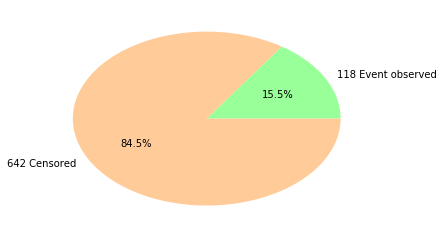

In [40]:
plt.figure()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(pie_num[-2:], labels=pct[-2:], colors=colors[-2:], autopct='%1.1f%%');
plt.savefig('data_num.png', dpi=300)

The age feature is quite interesting. I'd like to dig deeper to see if there are any patterns.

In [41]:
print(temp_drop['age_at_diagnosis'].min() / 365, '\n',
temp_drop['age_at_diagnosis'].max() / 365)

26.59178082191781 
 90.06027397260274


In [42]:
death = temp_drop.loc[temp_drop['observed'] == True]

In [43]:
print('death', '\n',
    death['age_at_diagnosis'].min(), '\t', death['age_at_diagnosis'].min() / 365, '\n',
death['age_at_diagnosis'].max(), '\t', death['age_at_diagnosis'].max() / 365)

death 
 9706.0 	 26.59178082191781 
 32872.0 	 90.06027397260274


In [44]:
censor = temp_drop.loc[temp_drop['observed'] == False]
print('censored', '\n',
    censor['age_at_diagnosis'].min(), '\t', censor['age_at_diagnosis'].min() / 365, '\n',
censor['age_at_diagnosis'].max(), '\t', censor['age_at_diagnosis'].max() / 365)

censored 
 9840.0 	 26.958904109589042 
 32872.0 	 90.06027397260274


In [45]:
temp_drop['age_at_diagnosis'].value_counts()

32872.0    6
23021.0    2
22199.0    2
24315.0    2
19415.0    2
29529.0    2
21910.0    2
18741.0    2
21628.0    2
21428.0    2
21479.0    2
14122.0    2
22798.0    2
14920.0    2
16736.0    2
19117.0    1
22703.0    1
26278.0    1
26988.0    1
19266.0    1
18594.0    1
18759.0    1
19836.0    1
29858.0    1
26548.0    1
24719.0    1
29115.0    1
16533.0    1
17346.0    1
28063.0    1
          ..
12525.0    1
23928.0    1
13680.0    1
21520.0    1
22688.0    1
19478.0    1
25370.0    1
18482.0    1
19989.0    1
20053.0    1
23507.0    1
29751.0    1
25674.0    1
19563.0    1
15903.0    1
32404.0    1
31173.0    1
22878.0    1
17996.0    1
23742.0    1
20072.0    1
24017.0    1
20570.0    1
21464.0    1
19596.0    1
22497.0    1
22094.0    1
18936.0    1
20804.0    1
21856.0    1
Name: age_at_diagnosis, Length: 741, dtype: int64

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


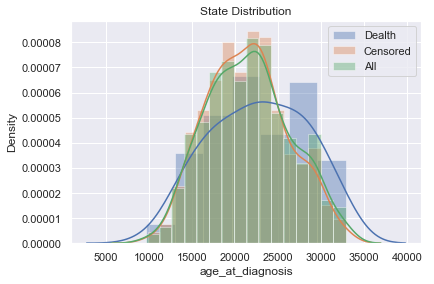

In [46]:
plt.figure()
sns.set()
sns.distplot(death['age_at_diagnosis'], label='Dealth');
sns.distplot(censor['age_at_diagnosis'], label='Censored');
sns.distplot(temp_drop['age_at_diagnosis'], label='All');
plt.legend()
plt.tight_layout()
plt.ylabel('Density')
plt.title('State Distribution');
plt.savefig('dis.png', dpi=300)